# 数据处理性能优化

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.6.0/tutorials/zh_cn/dataset/mindspore_optimize.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.6.0/tutorials/zh_cn/dataset/mindspore_optimize.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.6.0/tutorials/source_zh_cn/dataset/optimize.ipynb)

数据是整个深度学习中最重要的一环，因为数据的好坏决定了最终结果的上限，模型的好坏只是去无限逼近这个上限，所以高质量的数据输入，会在整个深度神经网络中起到积极作用，数据在整个数据处理和数据增强的过程像经过pipeline管道的水一样，源源不断地流向训练系统，如图所示：

![pipeline](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/pipeline.png)

MindSpore Dataset为用户提供了数据加载以及数据增强的功能，在数据的整个pipeline过程中，其中的每一步骤如果都能够进行合理的运用，那么数据的性能会得到很大的优化和提升。

本次体验将基于CIFAR-10数据集来为大家展示如何在数据加载、数据处理和数据增强的过程中进行性能的优化。

此外，操作系统的存储、架构和计算资源也会一定程度上影响数据处理的性能。

## 下载数据集

运行以下命令来获取数据集：

下载CIFAR-10二进制格式数据集，并将数据集文件解压到`./datasets/`目录下，数据加载的时候使用该数据集。

In [ ]:
from download import download
import os
import shutil

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"
path = download(url, "./datasets", kind="tar.gz", replace=True) # 下载CIFAR-10数据集

test_path = "./datasets/cifar-10-batches-bin/test"
train_path = "./datasets/cifar-10-batches-bin/train"
os.makedirs(test_path, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
if not os.path.exists(os.path.join(test_path, "test_batch.bin")):
    shutil.move("./datasets/cifar-10-batches-bin/test_batch.bin", test_path)
[shutil.move("./datasets/cifar-10-batches-bin/"+i, train_path) for i in os.listdir("./datasets/cifar-10-batches-bin/") if os.path.isfile("./datasets/cifar-10-batches-bin/"+i) and not i.endswith(".html") and not os.path.exists(os.path.join(train_path, i))]

解压后的数据集文件的目录结构如下：

```text
./datasets/cifar-10-batches-bin
├── readme.html
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin
```

## 数据加载性能优化

MindSpore支持加载计算机视觉、自然语言处理等领域的常用数据集、特定格式的数据集以及用户自定义的数据集。不同数据集加载接口的底层实现方式不同，性能也存在着差异，如下所示：

|          | 常用数据集 | 标准格式（MindRecord等） | 用户自定义 |
| :----:   | :----:     | :----:                   | :----:     |
| 底层实现 | C++        | C++                      | Python     |
| 性能     | 高         | 高                       | 中         |

可参考下图选择适合当前场景的数据集加载接口：

![data-loading-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/data_loading_performance_scheme.png)

数据加载性能优化建议如下：

- 对于已经提供加载接口的常用数据集，优先使用MindSpore提供的数据集加载接口进行加载，可以获得较好的加载性能，具体内容请参考框架提供的[数据集加载接口](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/mindspore.dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，即：将数据集接口的参数`num_parallel_workers`（默认值：8）增大来取得更好的性能。

- 不支持的数据集格式，推荐先将数据集转换为MindRecord数据格式后再使用`MindDataset`类进行加载（详细使用方法参考[API](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/dataset/mindspore.dataset.MindDataset.html)），具体内容请参考[将数据集转换为MindSpore数据格式](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/dataset/record.html)，如果性能仍无法满足需求，则可采取多线程并发方案，即：将数据集接口的参数`num_parallel_workers`（默认值：8）增大来取得更好的性能。

- 不支持的数据集格式，算法快速验证场景，优选用户自定义`GeneratorDataset`类实现（详细使用方法参考[API](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/dataset/mindspore.dataset.GeneratorDataset.html)），如果性能仍无法满足需求，则可采取多进程/多线程并发方案，即：

    1. 增大数据集接口的参数`num_parallel_workers`（默认值：1）来提升并发度；

    2. 将数据集接口的参数`python_multiprocessing`设置为`True(默认值)`/`False`来启动多进程模式/多线程模式，多进程模式适用于cpu计算密集型任务，多线程适用于IO密集型任务；

        **注意**：如果配置 `python_multiprocessing=True`（默认值：True）和 `num_parallel_workers>1`（默认值：1）表示启动了多进程方式进行数据load加速，此时随着数据集迭代，子进程的内存占用会逐渐增加，主要是因为自定义数据集的子进程以 Copy-On-Write 的方式获取主进程中的成员变量。举例：如果自定义数据集 `__init__` 函数中包含大量成员变量数据（例如：在数据集构建时加载了一个非常大的文件名列表）并且使用了多进程方式，那这可能会导致产生OOM的问题（总内存的预估使用量是：(子进程数量 + 1) * 父进程的内存大小）。最简单的解决方法是成员变量用非引用数据类型 （如：Pandas、Numpy或PyArrow对象）替换Python对象（如：list / dict / int / float / string等），或者加载更少的元数据以减小成员变量，或者配置 `python_multiprocessing=False` 使用多线程方式。

    3. 如果有`Using shared memory queue, but rowsize is larger than allocated memory ...`日志提示，那么将数据集接口的参数`max_rowsize`按日志提示进行增大或直接设为`None`来提升进程间数据传递的效率。

基于以上的数据加载性能优化建议，本次体验分别使用框架提供的数据集加载操作`Cifar10Dataset`类（详细使用方法参考[API](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/dataset/mindspore.dataset.Cifar10Dataset.html)）、数据转换后使用`MindDataset`类、使用`GeneratorDataset`类进行数据加载，代码演示如下：

1. 使用数据集加载操作`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，加载数据时采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [5]:
import mindspore.dataset as ds
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[181, 185, 194],
  [184, 187, 196],
  [189, 192, 201],
  ...
  [178, 181, 191],
  [171, 174, 183],
  [166, 170, 179]],
 [[182, 185, 194],
  [184, 187, 196],
  [189, 192, 201],
  ...
  [180, 183, 192],
  [173, 176, 185],
  [167, 170, 179]],
 [[185, 188, 197],
  [187, 190, 199],
  [193, 196, 205],
  ...
  [182, 185, 194],
  [176, 179, 188],
  [170, 173, 182]],
 ...
 [[176, 174, 185],
  [172, 171, 181],
  [174, 172, 183],
  ...
  [168, 171, 180],
  [164, 167, 176],
  [160, 163, 172]],
 [[172, 170, 181],
  [171, 169, 180],
  [173, 171, 182],
  ...
  [164, 167, 176],
  [160, 163, 172],
  [156, 159, 168]],
 [[171, 169, 180],
  [173, 171, 182],
  [177, 175, 186],
  ...
  [162, 165, 174],
  [158, 161, 170],
  [152, 155, 164]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 6)}


2. 使用`Cifar10ToMR`这个类将CIFAR-10数据集转换为MindSpore数据格式，这里使用的是CIFAR-10 python文件格式的数据集，然后使用`MindDataset`类加载MindSpore数据格式数据集，加载数据采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [6]:
from mindspore.mindrecord import Cifar10ToMR

trans_path = "./transform/"

if not os.path.exists(trans_path):
    os.mkdir(trans_path)

os.system("rm -f {}cifar10*".format(trans_path))

# download CIFAR-10 python
py_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-python.tar.gz"
download(py_url, "./datasets", kind="tar.gz", replace=True)

cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path, cifar10_mindrecord_path)
# execute transformation from CIFAR-10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_files=cifar10_mindrecord_path, num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator(output_numpy=True)))

{'data': Tensor(shape=[1289], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
   0,   2,   1,   1,   1,   1,   1,   2,   1,   1,   1,   2,   2,   2,   2,   2,   4,   3,   2,   2,   2,   2,   5,   4, 
   4,   3,   4,   6,   5,   6,   6,   6,   5,   6,   6,   6,   7,   9,   8,   6,   7,   9,   7,   6,   6,   8,  11,   8, 
   9,  10,  10,  10,  10,  10,   6,   8,  11,  12,  11,  10,  12,   9,  10,  10,  10, 255, 219,   0,  67,   1,   2,   2, 
   ...
   ...
   ...
  39, 227, 206, 143, 241,  91, 196, 154, 230, 189, 125, 165, 105, 218,  94, 163, 124, 146,  11, 187,  29,  34, 217, 210, 
  23, 186,  56,  14, 192,  19, 181,   1,  57,  36,  14,  51, 211, 173, 105,   9, 191, 100, 212, 174, 122,  25, 110,  39, 
  11, 133, 193, 226, 169,  73,  36, 234,  69,  90, 222,  93,  31, 223, 115, 255, 217]), 'id': Tensor(shape=[], dtype=Int64, value= 46084), 'label': Tensor(shape=[], dtype=Int64, value= 5)}


3. 使用`GeneratorDataset`类加载自定义数据集，并且采取多进程优化方案，开启了4个进程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [7]:
import numpy as np
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create GeneratorDataset for reading data
dataset = ds.GeneratorDataset(source=generator_func(5), column_names=["data"], num_parallel_workers=4)

# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## shuffle性能优化

shuffle操作主要是对有序的数据集或者进行过repeat的数据集进行混洗，MindSpore专门为用户提供了`shuffle`函数，它是基于内存缓存实现的，其中设定的`buffer_size`参数越大，混洗程度越大，但内存空间、时间消耗也会更大。该接口支持用户在整个pipeline的任何时候都可以对数据进行混洗，具体内容请参考[shuffle处理](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/dataset/dataset_method/operation/mindspore.dataset.Dataset.shuffle.html#mindspore-dataset-dataset-shuffle)。

但是因为它是基于内存缓存方式实现，该方式的性能不如直接在[数据集加载操作](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/mindspore.dataset.html)中设置`shuffle=True`（默认值：True）参数直接对数据进行混洗。

shuffle方案选择参考如下：

![shuffle-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/shuffle_performance_scheme.png)

shuffle性能优化建议如下：

- 直接使用数据集加载接口中的`shuffle=True`参数进行数据的混洗；

- 如果使用的是`shuffle`函数，当混洗效果无法满足需求，可通过调大`buffer_size`参数的值来优化混洗效果；当机器内存占用率过高时，可通过调小`buffer_size`参数的值来降低内存占用率。

基于以上的shuffle方案建议，本次体验分别使用数据集加载操作`Cifar10Dataset`类的`shuffle`参数和`shuffle`函数进行数据的混洗，代码演示如下：

1. 使用数据集加载接口`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，并且设置`shuffle`参数为True来进行数据混洗，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [8]:
cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[213, 205, 194],
  [215, 207, 196],
  [219, 210, 200],
  ...
  [253, 254, 249],
  [253, 254, 249],
  [253, 254, 249]],
 [[218, 208, 198],
  [220, 210, 200],
  [222, 212, 202],
  ...
  [253, 254, 249],
  [253, 254, 249],
  [253, 254, 249]],
 [[219, 209, 198],
  [222, 211, 200],
  [224, 214, 202],
  ...
  [254, 253, 248],
  [254, 253, 248],
  [254, 253, 248]],
 ...
 [[135, 141, 139],
  [135, 141, 139],
  [146, 152, 150],
  ...
  [172, 174, 172],
  [181, 182, 182],
  [168, 168, 167]],
 [[113, 119, 117],
  [109, 115, 113],
  [117, 123, 121],
  ...
  [155, 159, 156],
  [150, 155, 155],
  [135, 140, 140]],
 [[121, 127, 125],
  [117, 123, 121],
  [121, 127, 125],
  ...
  [180, 184, 180],
  [141, 146, 144],
  [125, 130, 129]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 8)}


2. 使用`shuffle`函数进行数据混洗，参数`buffer_size`设置为3，数据采用`GeneratorDataset`类自定义生成。

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[3 4 5 6 7]
[1 2 3 4 5]
[0 1 2 3 4]
[4 5 6 7 8]


## 数据增强性能优化

在训练任务中，尤其是当数据集比较小的时候，用户可以使用数据增强的方法来预处理图片，达到丰富数据集的目的。MindSpore为用户提供了多种数据增强操作，其中包括：

- Vision类数据增强操作，主要基于C++实现，见[Vision数据增强](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/mindspore.dataset.transforms.html#%E8%A7%86%E8%A7%89)。

- NLP类数据增强操作，主要基于C++实现，见[NLP数据增强](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/mindspore.dataset.transforms.html#%E6%96%87%E6%9C%AC)。

- Audio类数据增强操作，主要基于C++实现，见[Audio数据增强](https://www.mindspore.cn/docs/zh-CN/r2.6.0/api_python/mindspore.dataset.transforms.html#%E9%9F%B3%E9%A2%91)。

- 并且用户可根据特定的需求，自定义Python数据增强函数（Python实现）。

数据增强操作由于实现方式不同（C++实现 VS Python实现），其性能存在差异，具体如下所示：

| 编程语言 | 说明                         |
| :----:   | :----:                       |
| C++      | 使用C++代码实现，性能较高    |
| Python   | 使用Python代码实现，更加灵活 |

数据增强操作选择参考：

![data-enhancement-performance-scheme](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/data_enhancement_performance_scheme.png)

数据增强性能优化建议如下：

- 优先使用MindSpore提供的数据增强操作，能获得更好的性能，如果性能仍无法满足需求，可采取如下方式进行优化：

    1. 多线程优化

        增大`map`接口的参数`num_parallel_workers`（默认值：8）来取得更好的性能。

    2. 融合算子优化

        在当前CPU占用率比较高时（如：单机多卡训练），使用融合操作（将两个或多个操作的功能聚合到一个操作中）来降低CPU占用会获得更好性能，可以通过配置环境变量`export OPTIMIZE=true`来使其生效。融合示例如下：
        ![operation-fusion](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/operation_fusion.png)

    3. Compose优化

        在当前CPU占用率比较高时（如：单机多卡训练），通过一个map操作接收多个增强操作（会按照顺序应用这些操作）来降低CPU降低竞争以取得更好性能。示例如下：

        ![compose](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.6.0/tutorials/source_zh_cn/dataset/images/compose.png)

- 如果用户使用自定义Python函数进行数据增强，当性能仍无法满足需求，则可采取多进程/多线程并发方案，参考如下，但如果还是无法提升性能，就需要对自定义的Python函数进行优化。

    1. 增大`map`接口的参数`num_parallel_workers`（默认值：8）来提升并发度；

    2. 将`map`接口的参数`python_multiprocessing`设置为`True`/`False(默认值)`来启动多进程模式/多线程模式，多进程模式适用于cpu计算密集型任务，多线程适用于IO密集型任务；

    3. 如果有`Using shared memory queue, but rowsize is larger than allocated memory ...`日志提示，那么将`map`接口的参数`max_rowsize`按日志提示进行增大或直接设为`None`来提升进程间数据传递的效率。

基于以上的数据增强性能优化建议，本次体验分别使用实现在C++层的数据增强操作和自定义Python函数进行数据增强，演示代码如下所示：

1. 使用实现在C++层的数据增强操作，采用多线程优化方案，开启了4个线程并发完成任务，并且采用了融合算子优化方案，框架中使用`RandomResizedCrop`融合类替代`RandomResize`类和`RandomCrop`类。

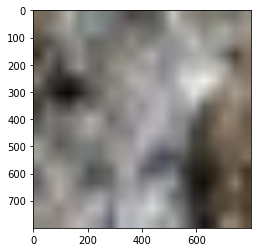

In [10]:
import mindspore.dataset.vision as vision
import matplotlib.pyplot as plt

cifar10_path = "./datasets/cifar-10-batches-bin/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
transforms = vision.RandomResizedCrop((800, 800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms, input_columns="image", num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. 使用自定义Python函数进行数据增强，数据增强时采用多进程优化方案，开启了4个进程并发完成任务。

In [11]:
def generator_func():
    for i in range(5):
        yield (np.array([i, i+1, i+2, i+3, i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

def preprocess(x):
    return (x**2,)
ds4 = ds3.map(operations=preprocess, input_columns="data", python_multiprocessing=True, num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## batch操作性能优化

在数据处理的最后阶段，会使用batch操作将多条数据组织成一个batch，然后再传递给网络用于训练。对于batch操作的性能优化建议如下：

- 如果仅配置了batch_size和drop_remainder，且batch_size比较大时，建议增大`num_parallel_workers`（默认值：8）来取得更好的性能；

- 如果使用了per_batch_map功能，那么建议配置如下：

    1. 增大参数`num_parallel_workers`（默认值：8）来提升并发度；

    2. 将参数`python_multiprocessing`设置为`True`/`False(默认值)`来启动多进程模式/多线程模式，多进程模式适用于cpu计算密集型任务，多线程适用于IO密集型任务；

    3. 如果有`Using shared memory queue, but rowsize is larger than allocated memory ...`日志提示，那么将`batch`接口的参数`max_rowsize`按日志提示进行增大或直接设为`None`来提升进程间数据传递的效率。

## 操作系统性能优化

由于MindSpore的数据处理主要在Host端进行，运行环境的配置也会对处理性能产生影响，主要体现在存储设备、NUMA架构和CPU计算资源等方面。

1. 存储设备

    数据的加载过程涉及频繁的磁盘操作，磁盘读写的性能直接影响了数据加载的速度。当数据集较大时，推荐使用固态硬盘进行数据存储，固态硬盘的读写速度普遍较普通磁盘高，能够减少I/O操作对数据处理性能的影响。

    一般地，加载后的数据将会被缓存到操作系统的页面缓存中，在一定程度上降低了后续读取的开销，加速了后续Epoch的数据加载速度。用户也可以通过MindSpore提供的[单节点缓存技术](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/dataset/cache.html)，手动缓存加载增强后的数据，避免了重复的数据加载和数据增强。

2. NUMA架构

    NUMA的全称为Non-Uniform Memory Access，即非一致性内存访问，是为了解决传统的对称多处理器（SMP）架构中的可扩展性问题而诞生的一种内存架构。在传统架构中，多个处理器共用一条内存总线，容易产生带宽不足、内存冲突等问题。

    而在NUMA架构中，处理器和内存被划分为多个组，每个组称为一个节点（Node），各个节点拥有独立的集成内存控制器（IMC）总线，用于节点内通信，不同节点间则通过快速路径互连（QPI）进行通信。对于某一节点来说，处在同节点内的内存被称为本地内存，处在其他节点的内存被称为外部内存，访问本地内存的延迟会小于访问外部内存的延迟。

    在数据处理过程中，可以通过将进程与节点绑定，来减小内存访问的延迟。一般我们可以使用以下命令进行进程与node节点的绑定，或者可以通过配置环境变量`export DATASET_ENABLE_NUMA=True`使得每个训练进程绑定至不同的numa节点。

    ```bash
    numactl --cpubind=0 --membind=0 python train.py
    ```

3. CPU计算资源

    尽管可以通过多线程并行技术加快数据处理的速度，但是实际运行时并不能保证CPU计算资源完全被利用起来。如果能够人为地事先完成计算资源配置的设定，将能在一定程度上提高CPU计算资源的利用率。

    - 计算资源的分配

        在分布式训练中，同一设备上可能开启多个训练进程。默认情况下，各个进程的资源分配与抢占将会遵循操作系统本身的策略进行，当进程较多时，频繁的资源竞争可能会导致数据处理性能的下降。如果能够事先设定各个进程的计算资源分配，就能避免这种资源竞争带来的开销。

        ```bash
        numactl --cpubind=0 python train.py
        ```

    - CPU频率设置

        出于节约能效的考虑，操作系统会根据需要适时调整CPU的运行频率，但更低的功耗意味着计算性能的下降，会减慢数据处理的速度。要想充分发挥CPU的最大算力，需要手动设置CPU的运行频率。如果发现操作系统的CPU运行模式为平衡模式或者节能模式，可以通过将其调整为性能模式，提升数据处理的性能。

        ```bash
        cpupower frequency-set -g performance
        ```

    - 多线程竞争

        如果用户在数据处理阶段使用了`cv2`，`numpy`，`numba`三方库，且使用`top`命令查看CPU时，出现`sy`占用高，而`us`占用低，说明出现了线程竞争，那么通过如下方式解决：
        1. 如果数据处理阶段有 `opencv` 的 `cv2` 操作，那么通过 `cv2.setNumThreads(2)` 设置 `cv2` 全局线程数减少线程竞争；
        2. 如果数据处理阶段有 `numpy` 操作，那么通过 `export OPENBLAS_NUM_THREADS=1` 设置OPENBLAS线程数减少线程竞争；
        3. 如果数据处理阶段有 `numba` 操作，那么通过 `numba.set_num_threads(1)` 设置并行度来减少线程竞争。

    - CPU/内存占用率高

        因为MindSpore Dataset主要是使用Host侧CPU和内存做数据处理，在一些资源（CPU和Memory）比较紧张的环境，在进行数据预处理时会出现CPU占用过高，或者内存占用高的情况。那么可以通过如下方法降低CPU及内存占用率，但同时也会损失一些性能。更详细的使用指导可参考：https://blog.csdn.net/guozhijian521/article/details/123552540
        1. 在定义数据集 `**Dataset` 对象前，设置Dataset数据处理预取的大小，`ds.config.set_prefetch_size(2)`；
        2. 在定义 `**Dataset` 对象时，设置其参数 `num_parallel_workers` 为1；
        3. 如果对 `**Dataset` 对象进一步使用了 `.map(...)` 操作，可以设置 `.map(...)` 的参数 `num_parallel_workers` 为1；
        4. 如果对 `**Dataset` 对象进一步使用了 `.batch(...)` 操作，可以设置 `.batch(...)` 的参数 `num_parallel_workers` 为1；
        5. 如果对 `**Dataset` 对象进一步使用了 `.shuffle(...)` 操作，可以把参数 `buffer_size` 设置减少；
        6. 如果有多个 `.map(...)` 操作，可以将多个 `.map(...)` 操作合并为一个。

## 单卡训练 VS 多卡训练并行度优化建议

在使用MindSpore进行单卡或多卡训练时，num_parallel_workers参数的设置应遵循以下原则：

- 各数据加载和处理操作所设置的num_parallel_workers参数之和应不大于CPU所支持的最大线程数，否则将造成各个操作间的资源竞争。

- 在设置num_parallel_workers参数之前，建议先使用MindSpore的Profiler(性能分析)工具分析训练中各个操作的性能情况，将更多的资源分配给性能较差的操作，即设置更大的num_parallel_workers，使得各个操作之间的吞吐达到平衡，避免不必要的等待。

- 在单卡训练场景中，提高num_parallel_workers参数往往能直接提高处理性能，但在多卡场景下，由于CPU竞争加剧，一味地提高num_parallel_workers可能会导致性能劣化，需要在实际训练中尝试使用折中数值。

## 自动数据加速

MindSpore提供了一种自动数据调优的工具——Dataset AutoTune，用于在训练过程中根据环境资源的情况自动调整数据处理管道的并行度，最大化利用系统资源加速数据处理管道的处理速度。详细用法请参考[自动数据加速](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/dataset/dataset_autotune.html)。

## 数据异构加速

MindSpore提供了一种运算负载均衡的技术，可以将MindSpore的Tensor运算分配到不同的异构硬件上，一方面均衡不同硬件之间的运算开销，另一方面利用异构硬件的优势对运算进行加速。详细用法请参考[数据异构加速](https://www.mindspore.cn/tutorials/zh-CN/r2.6.0/dataset/dataset_offload.html)。